In [6]:
#importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import folium

from tqdm import tqdm

register_matplotlib_converters()

COVID19_PATH = "data/raw_data/covid-19-state-level-data.csv"
GOOGLE_MOBILITY_PATH = 'data/raw_data/us-mobility.csv'

#loading the state level Covid 19 dataset
covid19_df = pd.read_csv(COVID19_PATH, index_col=0)
google_mobility_df = pd.read_csv(GOOGLE_MOBILITY_PATH, index_col=0)

In [7]:
covid19_df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [8]:
google_mobility_df.head()

,state,county,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,Total,Total,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
1,Total,Total,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0
2,Total,Total,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0
3,Total,Total,2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0
4,Total,Total,2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0


In [9]:
# get only total data

google_mobility_df = google_mobility_df[google_mobility_df['county'] == 'Total']

google_mobility_df.head()

,state,county,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,Total,Total,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
1,Total,Total,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0
2,Total,Total,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0
3,Total,Total,2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0
4,Total,Total,2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0


In [10]:
c_missing, c_found = 0, 0

records = []
for ix, row in tqdm(list(covid19_df.iterrows())):
    data = google_mobility_df[(google_mobility_df['date'] == row['date'])& (google_mobility_df['state'].str.lower() == row['state'].lower())]
    if len(data) == 0:
        c_missing += 1
    else:
        c_found += 1
        data = data.iloc[:,3:].mean().to_dict()
        data.update(row.to_dict())
        records.append(data)

print(c_missing, c_found)
        
df = pd.DataFrame(records)

df.head()

100%|██████████| 8154/8154 [00:48<00:00, 167.58it/s]

802 7352


,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,date,state,fips,cases,deaths
0,3.0,2.0,13.0,3.0,-1.0,0.0,2020-02-15,Arizona,4,1,0
1,1.0,1.0,19.0,1.0,-1.0,0.0,2020-02-15,California,6,7,0
2,4.0,3.0,10.0,3.0,3.0,-1.0,2020-02-15,Illinois,17,2,0
3,2.0,-4.0,0.0,3.0,-2.0,0.0,2020-02-15,Massachusetts,25,1,0
4,3.0,3.0,12.0,3.0,1.0,-1.0,2020-02-15,Texas,48,2,0


In [29]:
states = set(df['state'])

len(states)

51

In [30]:
df = df.assign(date=pd.to_datetime(df['date']))

min(df['date']), max(df['date'])

(Timestamp('2020-02-15 00:00:00'), Timestamp('2020-07-25 00:00:00'))

In [31]:
df

,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,date,state,fips,cases,deaths
0,3.0,2.0,13.0,3.0,-1.0,0.0,2020-02-15,Arizona,4,1,0
1,1.0,1.0,19.0,1.0,-1.0,0.0,2020-02-15,California,6,7,0
2,4.0,3.0,10.0,3.0,3.0,-1.0,2020-02-15,Illinois,17,2,0
3,2.0,-4.0,0.0,3.0,-2.0,0.0,2020-02-15,Massachusetts,25,1,0
4,3.0,3.0,12.0,3.0,1.0,-1.0,2020-02-15,Texas,48,2,0
...,...,...,...,...,...,...,...,...,...,...,...
7347,-17.0,2.0,125.0,-15.0,-13.0,3.0,2020-07-25,Virginia,51,83609,2075
7348,-21.0,-1.0,164.0,-16.0,-15.0,2.0,2020-07-25,Washington,53,53884,1592
7349,-10.0,7.0,163.0,38.0,-11.0,1.0,2020-07-25,West Virginia,54,5821,103
7350,-11.0,12.0,296.0,9.0,-5.0,1.0,2020-07-25,Wisconsin,55,51735,900


In [33]:
records = []

errors = []
for state in tqdm(set(df['state'])):
    for date in pd.date_range(min(df['date']), max(df['date'])):
        data = df[(df['date'] == date) & (df['state'] == state)]
        if len(data) == 0:
            records.append({
                'date': date,
                'state': state,
            })
        else:
            if len(data) > 1:
                errors.append(len(data))
                print('ERROR: found more than one record')
            data = data.drop(['date', 'state'], axis=1).mean().to_dict()
            data.update({
                'date': date,
                'state': state,
            })
            records.append(data)

df = pd.DataFrame(records)

100%|██████████| 51/51 [00:22<00:00,  2.24it/s]


In [34]:
df = df.fillna(0)

In [37]:
df.head()

,date,state,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,fips,cases,deaths
0,2020-02-15,Vermont,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-02-16,Vermont,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-02-17,Vermont,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-02-18,Vermont,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-02-19,Vermont,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
df.to_csv('data/processed_data/covid-19-state-level.csv')

In [13]:
state_data = df.groupby('state')['cases'].max().to_frame()

state_data = state_data.assign(cases_p=state_data['cases'] / state_data['cases'].sum())

state_data = state_data.sort_values(by=['cases'], ascending=False).reset_index()

state_data.head()

,state,cases,cases_p
0,California,453327,0
1,New York,415911,0
2,Florida,414503,0
3,Texas,391609,0
4,New Jersey,180778,0


In [14]:
max_date = df['date'].max()

str(max_date)

'2020-07-25'

In [15]:
state_codes = {row.State: row.Abbreviation for row in pd.read_csv('./resources/us-state-codes.csv').itertuples()}

state_data = state_data.assign(state_code=state_data['state'].apply(lambda x: state_codes[x]))

In [16]:
state_geo = './resources/us-states.json'

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='Total COVID-19 Cases',
    data=state_data,
    columns=['state_code', 'cases_p'],
    key_on='feature.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Total Number of COVID-19 Cases till {} (%)'.format(max_date)
).add_to(m)

folium.LayerControl().add_to(m)

m

In [ ]:
df.columns

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(25, 10), sharey=True)

fig.suptitle('Number of COVID-19 cases for states with maximum cases.')

for i, state in enumerate(state_data[:6]['state']):
    y_dealths = df[df.state==state]['deaths'][1:].reset_index(drop=True) - df[df.state==state]['deaths'][:-1].reset_index(drop=True)
    y_cases = df[df.state==state]['cases'][1:].reset_index(drop=True) - df[df.state==state]['cases'][:-1].reset_index(drop=True)
    y_work = df[df.state==state]['transit_stations'][1:] * 100

    x_date = df[df.state==state]['date'][1:] 

    axs[i % 2][i // 2].plot(x_date, y_dealths, label='Deaths')
    axs[i % 2][i // 2].plot(x_date, y_cases, label='Cases')
    axs[i % 2][i // 2].plot(x_date, y_work, label='Work')
    axs[i % 2][i // 2].legend()
    
plt.ylabel('Number of Cases/Deaths')
plt.show()

,state,cases,cases_p
0,California,453327.0,0.108602
1,New York,415911.0,0.099638
2,Florida,414503.0,0.099301
3,Texas,391609.0,0.093816
4,New Jersey,180778.0,0.043308


In [80]:
max_date = df['date'].max()

str(max_date)

'2020-07-25 00:00:00'

In [101]:
state_codes = {row.State: row.Abbreviation for row in pd.read_csv('./resources/us-state-codes.csv').itertuples()}

state_data = state_data.assign(state_code=state_data['state'].apply(lambda x: state_codes[x]))

In [104]:
state_geo = './resources/us-states.json'

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='Total COVID-19 Cases',
    data=state_data,
    columns=['state_code', 'cases_p'],
    key_on='feature.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Total Number of COVID-19 Cases till {} (%)'.format(max_date)
).add_to(m)

folium.LayerControl().add_to(m)

m

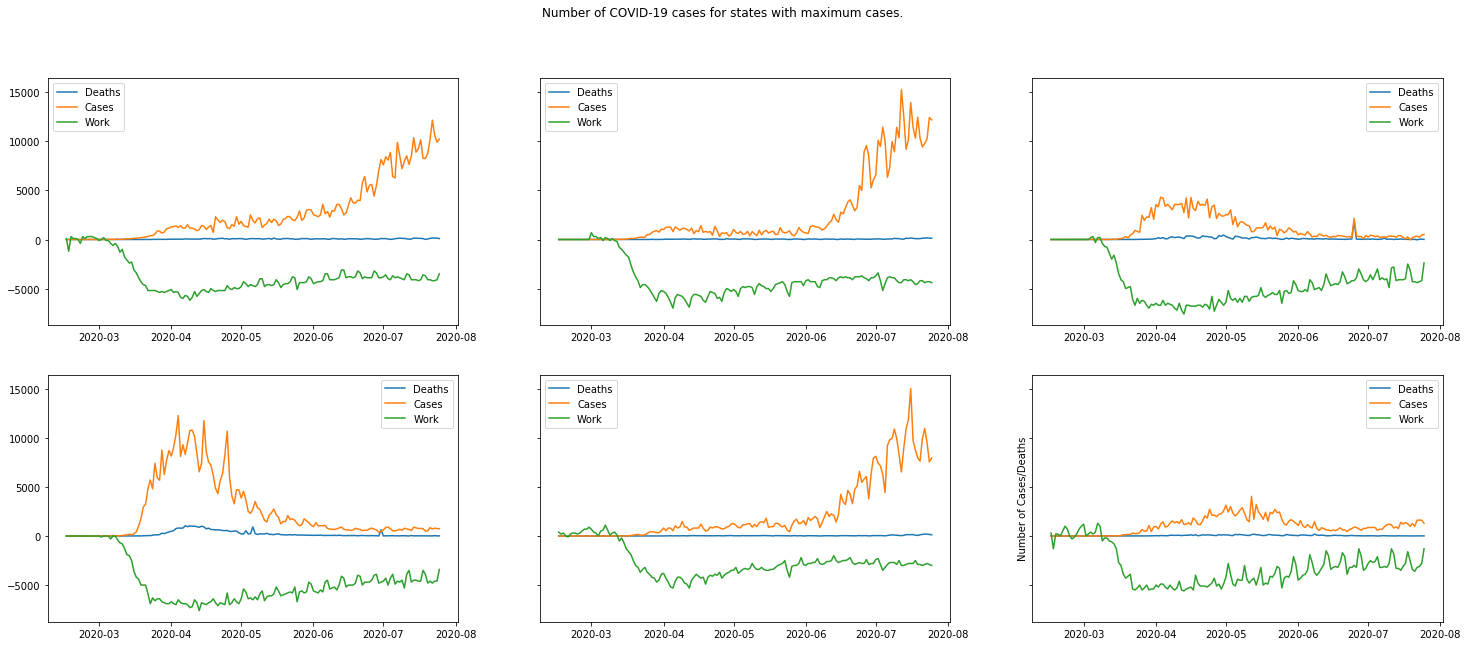

In [181]:
fig, axs = plt.subplots(2, 3, figsize=(25, 10), sharey=True)

fig.suptitle('Number of COVID-19 cases for states with maximum cases.')

for i, state in enumerate(state_data[:6]['state']):
    y_dealths = df[df.state==state]['deaths'][1:].reset_index(drop=True) - df[df.state==state]['deaths'][:-1].reset_index(drop=True)
    y_cases = df[df.state==state]['cases'][1:].reset_index(drop=True) - df[df.state==state]['cases'][:-1].reset_index(drop=True)
    y_work = df[df.state==state]['transit_stations'][1:] * 100

    x_date = df[df.state==state]['date'][1:] 

    axs[i % 2][i // 2].plot(x_date, y_dealths, label='Deaths')
    axs[i % 2][i // 2].plot(x_date, y_cases, label='Cases')
    axs[i % 2][i // 2].plot(x_date, y_work, label='Work')
    axs[i % 2][i // 2].legend()
    
plt.ylabel('Number of Cases/Deaths')
plt.show()